# P0: Intro

<center><b>Machine Learning Project</b></center>
<br><center><b>Sharif University of Technology - Fall 2023</b></center>

Author: Soheil Nazari Mendejin <br>
99102412

In this project, I created a sentiment analysis model using comments from two major Persian websites: Snappfood, for food delivery, and Digikala, an online shopping platform. The work involved training a neural network to understand user sentiments from Snappfood and then fine-tuning it with Digikala comments to address the challenge of changing contexts. This project highlights my skills in machine learning and natural language processing, demonstrating my ability to manage complex data and adapt models to new domains.

# P1: Exploring the Datasets (25 points)

Both of the datasets are added to the notebook. In this part, we want to explore their contents. 

Load both of the datasets 

In [1]:
import pandas as pd
from tensorflow.keras.models import model_from_json
snappfood_data = pd.read_csv('/kaggle/input/snappfood-persian-sentiment-analysis/Snappfood - Sentiment Analysis.csv', sep='\t+', engine='python')
digikala_data = pd.read_csv('/kaggle/input/digikala-comments-persian-sentiment-analysis/data.csv')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Count the number of comments each dataset contains **(P1-1: 5 points)**

In [2]:
print(f"Snappfood Comments: {len(snappfood_data)}")
print(f"Digikala Comments: {len(digikala_data)}")

Snappfood Comments: 70000
Digikala Comments: 3261


Represent the distribution of comments in the Snappfood dataset in terms of being negative or positive **(P1-2: 5 points)**

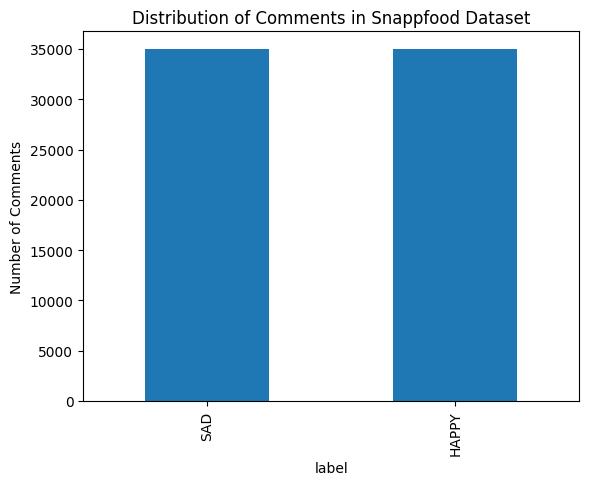

In [3]:
import matplotlib.pyplot as plt
snappfood_data['label'].value_counts().plot(kind='bar')

plt.title('Distribution of Comments in Snappfood Dataset')
plt.xlabel('label')
plt.ylabel('Number of Comments')
plt.show()

Plot the logarithm of the frequency of words as a function of the logarithm of their rank to demonstrate the Zipf's law. <br>
Note: Don't panic! The Zipf's law can be found here: https://nlp.stanford.edu/IR-book/html/htmledition/zipfs-law-modeling-the-distribution-of-terms-1.html and can be easily understood. **(P1-3: 5 points)**

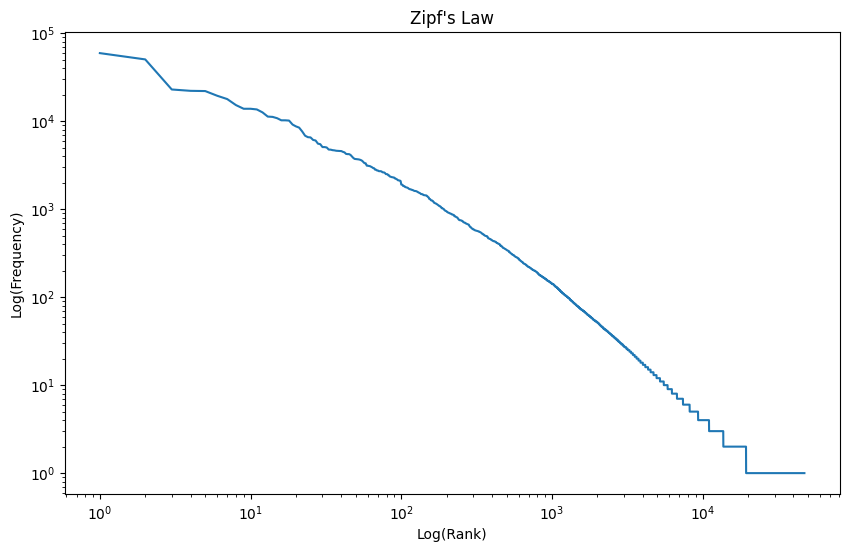

In [4]:
from collections import Counter
import numpy as np
all_text = ' '.join(snappfood_data['comment'])
words = all_text.split()
word_counts = Counter(words)
counts = np.array(sorted(word_counts.values(), reverse=True))
ranks = np.arange(1, len(counts) + 1)
plt.figure(figsize=(10,6))
plt.loglog(ranks, counts)
plt.title("Zipf's Law")
plt.xlabel('Log(Rank)')
plt.ylabel('Log(Frequency)')
plt.show()

Add a new column to the Digikala dataset indicating whether the comment was positive, negative, or neutral. This will be needed later for classification. <br>
Note: This can be done in many ways. You should the appropriate method. **(P1-4: 5 points)**


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def score_to_sentiment(score):
    if score >= 55:
        return 'positive'
    elif score >= 45:
        return 'neutral'
    else:
        return 'negative'

digikala_data['Sentiment'] = digikala_data['Score'].apply(score_to_sentiment)
X_train, X_test, y_train, y_test = train_test_split(digikala_data['Text'], digikala_data['Sentiment'], test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()
tokenized_train = [word_tokenize(comment.lower()) for comment in X_train]
tokenized_test = [word_tokenize(comment.lower()) for comment in X_test]
w2v_model = Word2Vec(tokenized_train, vector_size=100, window=5, min_count=1, workers=4)
w2v_model.train(tokenized_train, total_examples=len(tokenized_train), epochs=10)
def document_vector(doc, model):
    doc = [word for word in doc if word in model.wv.index_to_key]
    return np.mean(model.wv[doc], axis=0) if len(doc) > 0 else np.zeros(model.vector_size)
X_train_w2v = np.array([document_vector(doc, w2v_model) for doc in tokenized_train])
X_test_w2v = np.array([document_vector(doc, w2v_model) for doc in tokenized_test])
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)
input_tfidf = Input(shape=(X_train_tfidf.shape[1],))
input_w2v = Input(shape=(w2v_model.vector_size,))
layer_tfidf = Dense(128, activation='relu')(input_tfidf)
layer_w2v = Dense(128, activation='relu')(input_w2v)
merged = concatenate([layer_tfidf, layer_w2v])
merged = Dense(256, activation='relu')(merged)
output = Dense(y_train_categorical.shape[1], activation='softmax')(merged)
model = Model(inputs=[input_tfidf, input_w2v], outputs=output)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit([X_train_tfidf, X_train_w2v], y_train_categorical, epochs=10, batch_size=32)
loss, accuracy = model.evaluate([X_test_tfidf, X_test_w2v], y_test_categorical)
print(f'Accuracy: {accuracy}')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Epoch 1/10
82/82 [==============================] - 3s 3ms/step - loss: 0.4848 - accuracy: 0.8593
Epoch 2/10
82/82 [==============================] - 0s 3ms/step - loss: 0.3195 - accuracy: 0.8792
Epoch 3/10
82/82 [==============================] - 0s 3ms/step - loss: 0.1619 - accuracy: 0.9410
Epoch 4/10
82/82 [==============================] - 0s 4ms/step - loss: 0.0585 - accuracy: 0.9858
Epoch 5/10
82/82 [==============================] - 0s 3ms/step - loss: 0.0169 - accuracy: 0.9965
Epoch 6/10
82/82 [==============================] - 0s 3ms/step - loss: 0.0053 - accuracy: 0.9996
Epoch 7/10
82/82 [==============================] - 0s 3ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 8/10
82/82 [==============================] - 0s 3ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 9/10
82/82 [==============================] - 0s 3ms/step - loss: 7.1215e-04 - accuracy: 1.000

Split each dataset into training, testing, and validation sets. **(P1-5: 5 points)**

In [6]:
train_snappfood, test_snappfood = train_test_split(snappfood_data, test_size=0.3, random_state=42)
val_snappfood, test_snappfood = train_test_split(test_snappfood, test_size=0.5, random_state=42)
train_digikala, test_digikala = train_test_split(digikala_data, test_size=0.3, random_state=42)
val_digikala, test_digikala = train_test_split(test_digikala, test_size=0.5, random_state=42)

# P2: Preprocessing and Feature Extraction (20 points)

The goal of this part is to make the Snappfood dataset ready for the neural network to be trained with.<br>
Note: You can use many libraries including `NLTK`, `Spacy`, `Hazm`, `Parsivar`, `Stanza` etc.

Remove the unnecessary characters of the dataset. <br>
**(P2-1: 5 points)**

In [7]:
import re
import pandas as pd
!pip install hazm


from hazm import Normalizer

normalizer = Normalizer()

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text
snappfood_data['comment'] = snappfood_data['comment'].apply(clean_text)

  Obtaining dependency information for hazm from https://files.pythonhosted.org/packages/91/8c/cc3d01c27681eb8223781ea162a23f9926647ce864eb601a19aee4bce0af/hazm-0.10.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 68.2 MB/s eta 0:00:00
  Obtaining dependency information for python-crfsuite<0.10.0,>=0.9.9 from https://files.pythonhosted.org/packages/38/1d/c475ba7d11e9735f00eb08e2f5315aa2e21c24cc85a0474c3fd425edef58/python_crfsuite-0.9.10-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.5 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all

Normalize the dataset. <br>
Note: Check the result. For instance, if you do this correctly, you'll have a dataset containing just 1 type of space. **(P2-2: 5 points)**

In [8]:
def normalize_text(text):
    return normalizer.normalize(text)
snappfood_data['comment'] = snappfood_data['comment'].apply(normalize_text)


If you want to include other preprocessing steps, put all of your code here.

In [9]:
from hazm import Normalizer, word_tokenize, stopwords_list, Stemmer
stemmer = Stemmer()

def preprocess_text(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords_list()]
    words = [stemmer.stem(word) for word in words]
    text = ' '.join(words)
    return text

snappfood_data['comment'] = snappfood_data['comment'].apply(preprocess_text)

Extract features from the Snappfood dataset
<br> Note: You should use both of the following methods, and compare the results at the end.
- Method 1 (Classic): Use `CountVectorizer` or `TF-IDF`.
- Method 2 (Modern): Use `Word2Vec`, `FastText`, `GloVe`, `Doc2Vec` or train your own `Embedding` Layer. 

If you choose to train your own `Embedding`s, you'll just need to specify an ID for each word remaining in your dataset. **(P2-3: 10 points)**

In [10]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_features = tfidf_vectorizer.fit_transform(snappfood_data['comment'])

tokenized_comments = [comment.split() for comment in snappfood_data['comment']]
w2v_model = Word2Vec(tokenized_comments, vector_size=100, window=5, min_count=1, workers=4)
w2v_model.train(tokenized_comments, total_examples=len(tokenized_comments), epochs=10)
def comment_vector(comment, model):
    words = [word for word in comment if word in model.wv.index_to_key]
    if len(words) >= 1:
        return np.mean(model.wv[words], axis=0)
    else:
        return np.zeros(model.vector_size)

w2v_features = np.array([comment_vector(comment, w2v_model) for comment in tokenized_comments])

# P3: Training and Initial Evaluation (20 points)

Define an architecture for your neural network. **(P3-1: 5 points)**

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, accuracy_score
def build_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_tfidf = build_model(input_dim=tfidf_features.shape[1])
model_word2vec = build_model(input_dim=w2v_features.shape[1])

Train the network on the Snappfood dataset, while monitoring its performance on the validation set. **(P3-2: 5 points)**

Epoch 1/10
1532/1532 [==============================] - 8s 4ms/step - loss: 0.3811 - accuracy: 0.8333 - val_loss: 0.3402 - val_accuracy: 0.8516
Epoch 2/10
1532/1532 [==============================] - 5s 3ms/step - loss: 0.3115 - accuracy: 0.8686 - val_loss: 0.3454 - val_accuracy: 0.8517
Epoch 3/10
1532/1532 [==============================] - 5s 3ms/step - loss: 0.2806 - accuracy: 0.8853 - val_loss: 0.3562 - val_accuracy: 0.8528
Epoch 4/10
1532/1532 [==============================] - 5s 3ms/step - loss: 0.2488 - accuracy: 0.9019 - val_loss: 0.3746 - val_accuracy: 0.8518
Epoch 5/10
1532/1532 [==============================] - 5s 3ms/step - loss: 0.2124 - accuracy: 0.9186 - val_loss: 0.4144 - val_accuracy: 0.8456
Epoch 6/10
1532/1532 [==============================] - 5s 3ms/step - loss: 0.1830 - accuracy: 0.9305 - val_loss: 0.4391 - val_accuracy: 0.8415
Epoch 7/10
1532/1532 [==============================] - 5s 3ms/step - loss: 0.1552 - accuracy: 0.9418 - val_loss: 0.4953 - val_accuracy:

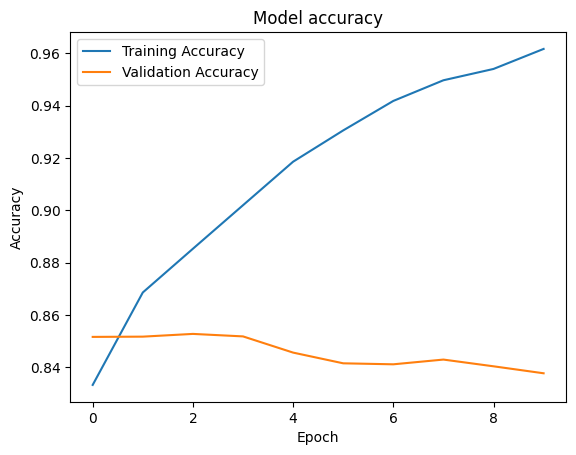

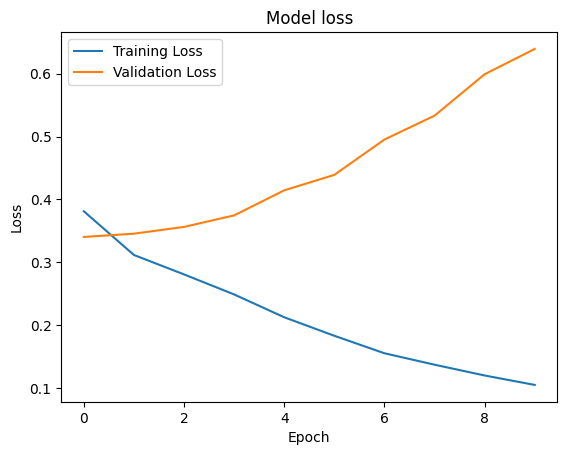

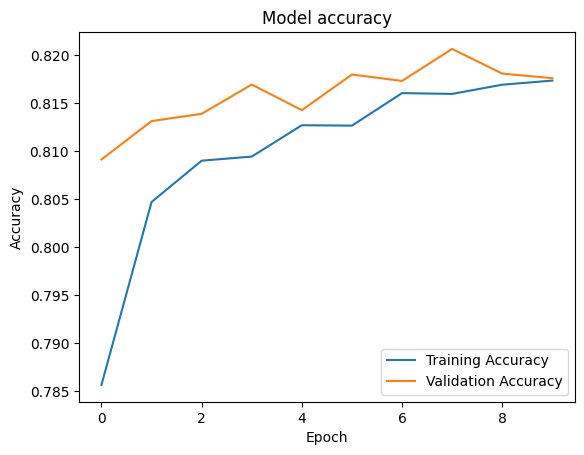

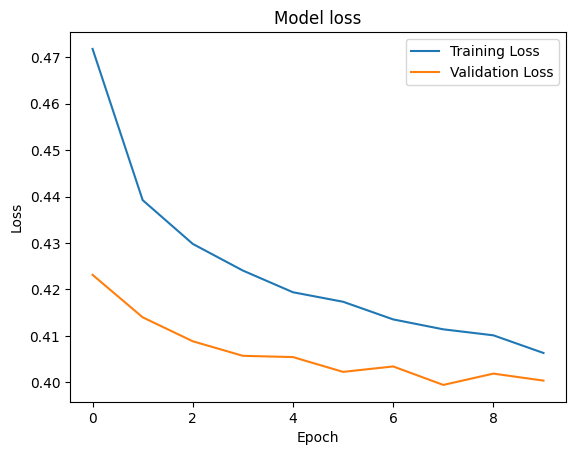

In [12]:
X_train_tfidf = tfidf_vectorizer.fit_transform(train_snappfood['comment']).toarray()
y_train_tfidf = train_snappfood['label_id'].values
X_val_tfidf = tfidf_vectorizer.transform(val_snappfood['comment']).toarray()
y_val_tfidf = val_snappfood['label_id'].values

train_snappfood['tokenized_comment'] = train_snappfood['comment'].apply(word_tokenize)
val_snappfood['tokenized_comment'] = val_snappfood['comment'].apply(word_tokenize)
X_train_w2v = np.array([comment_vector(comment, w2v_model) for comment in train_snappfood['tokenized_comment']])
X_val_w2v = np.array([comment_vector(comment, w2v_model) for comment in val_snappfood['tokenized_comment']])
y_train_w2v = train_snappfood['label_id'].values
y_val_w2v = val_snappfood['label_id'].values

model_tfidf = build_model(input_dim=X_train_tfidf.shape[1])
history_tfidf = model_tfidf.fit(X_train_tfidf, y_train_tfidf, epochs=10, batch_size=32, validation_data=(X_val_tfidf, y_val_tfidf))

model_w2v = build_model(input_dim=X_train_w2v.shape[1])
history_w2v = model_w2v.fit(np.array(X_train_w2v), y_train_w2v, epochs=10, batch_size=32, validation_data=(np.array(X_val_w2v), y_val_w2v))

plt.plot(history_tfidf.history['accuracy'], label='Training Accuracy')
plt.plot(history_tfidf.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history_tfidf.history['loss'], label='Training Loss')
plt.plot(history_tfidf.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history_w2v.history['accuracy'], label='Training Accuracy')
plt.plot(history_w2v.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history_w2v.history['loss'], label='Training Loss')
plt.plot(history_w2v.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


Evaluate the performance of your network on the Snappfood testing set. **(P3-3: 5 points)**

In [13]:
X_test_tfidf = tfidf_vectorizer.transform(test_snappfood['comment']).toarray()
y_test_tfidf = test_snappfood['label_id'].values
test_snappfood['tokenized_comment'] = test_snappfood['comment'].apply(word_tokenize)
X_test_w2v = np.array([comment_vector(comment, w2v_model) for comment in test_snappfood['tokenized_comment']])
y_test_w2v = test_snappfood['label_id'].values
predictions_tfidf = model_tfidf.predict(X_test_tfidf)
predictions_w2v = model_w2v.predict(np.array(X_test_w2v))

predictions_tfidf_binary = (predictions_tfidf > 0.5).astype(int)
print("Performance with TF-IDF Features:")
print(classification_report(y_test_tfidf, predictions_tfidf_binary))
print("Accuracy:", accuracy_score(y_test_tfidf, predictions_tfidf_binary))

predictions_w2v_binary = (predictions_w2v > 0.5).astype(int)
print("Performance with Word2Vec Features:")
print(classification_report(y_test_w2v, predictions_w2v_binary))
print("Accuracy:", accuracy_score(y_test_w2v, predictions_w2v_binary))



329/329 [==============================] - 1s 2ms/step
Performance with TF-IDF Features:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      5215
           1       0.83      0.84      0.84      5285

    accuracy                           0.83     10500
   macro avg       0.83      0.83      0.83     10500
weighted avg       0.83      0.83      0.83     10500

Accuracy: 0.8331428571428572
Performance with Word2Vec Features:
              precision    recall  f1-score   support

           0       0.87      0.74      0.80      5215
           1       0.78      0.89      0.83      5285

    accuracy                           0.82     10500
   macro avg       0.82      0.82      0.82     10500
weighted avg       0.82      0.82      0.82     10500

Accuracy: 0.8173333333333334


Save the weights of the neural network and its architecture seperately in the notebook's output folder (`/kaggle/working/`). **(P3-4: 5 points)**

In [14]:
model_tfidf.save_weights('/kaggle/working/model_tfidf_weights.h5')
model_tfidf_json = model_tfidf.to_json()
with open("/kaggle/working/model_tfidf_architecture.json", "w") as json_file:
    json_file.write(model_tfidf_json)
    
model_w2v.save_weights('/kaggle/working/model_w2v_weights.h5')
model_w2v_json = model_w2v.to_json()
with open("/kaggle/working/model_w2v_architecture.json", "w") as json_file:
    json_file.write(model_w2v_json)

# P4: Fine-tuning and Evaluation (35 points)

In this part, we will fine-tune the previously trained network on the comments extracted from Digikala.

Load the neural network along with its weights **(P4-1: 5 points)**

In [15]:
with open('/kaggle/working/model_tfidf_architecture.json', 'r') as json_file:
    loaded_model_tfidf_json = json_file.read()
loaded_model_tfidf = model_from_json(loaded_model_tfidf_json)
loaded_model_tfidf.load_weights('/kaggle/working/model_tfidf_weights.h5')

with open('/kaggle/working/model_w2v_architecture.json', 'r') as json_file:
    loaded_model_w2v_json = json_file.read()
loaded_model_w2v = model_from_json(loaded_model_w2v_json)
loaded_model_w2v.load_weights('/kaggle/working/model_w2v_weights.h5')

Change the architecture of the network (the last layer) to make it appropriate for classifying the sentiment of a comment in one of the previously mentioned three classes: positive, negative, or neutral. **(P4-2: 5 points)**

In [16]:
model_tfidf.pop()
new_output_tfidf = Dense(3, activation='softmax')(model_tfidf.layers[-1].output)
new_model_tfidf = Model(inputs=model_tfidf.input, outputs=new_output_tfidf)
new_model_tfidf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_w2v.pop()
new_output_w2v = Dense(3, activation='softmax')(model_w2v.layers[-1].output)
new_model_w2v = Model(inputs=model_w2v.input, outputs=new_output_w2v)
new_model_w2v.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Extract features from the Digikala dataset.<br>
Note: Pay attention to the fact that your features are the same as the ones you extracted from the Snappfood dataset. You just need to use the same method for the new dataset. For instance, if you consider the `CountVectorizer` as your feature extractor, the set of the words for which you'll count the frequency will not change! **(P4-3: 15 points)**

In [17]:
X_digikala_tfidf = tfidf_vectorizer.transform(digikala_data['Text']).toarray()

digikala_data['tokenized_text'] = digikala_data['Text'].apply(word_tokenize)
X_digikala_w2v = np.array([comment_vector(comment, w2v_model) for comment in digikala_data['tokenized_text']])

label_encoder = LabelEncoder()
y_digikala_encoded = label_encoder.fit_transform(digikala_data['Sentiment'])

y_digikala_categorical = to_categorical(y_digikala_encoded)

y_digikala_w2v = y_digikala_tfidf = y_digikala_categorical

Fine-tune the network on the training set associated with the Digikala dataset, while monitoring its performance on the corresponding validation set.<br>
Note: The process of fine-tuning should follow one of these methods:
- Method 1: Fix the weights for all layers expect the last one.
- Method 2: Use a really small learning rate for all layers except the last one.

**(P4-4: 5 points)**

In [18]:
from tensorflow.keras.optimizers import Adam

X_train_tfidf, X_temp_tfidf, y_train_tfidf, y_temp_tfidf = train_test_split(X_digikala_tfidf, y_digikala_categorical, test_size=0.3, random_state=42)
X_val_tfidf, X_test_tfidf, y_val_tfidf, y_test_tfidf = train_test_split(X_temp_tfidf, y_temp_tfidf, test_size=0.5, random_state=42)

X_train_w2v, X_temp_w2v, y_train_w2v, y_temp_w2v = train_test_split(X_digikala_w2v, y_digikala_categorical, test_size=0.3, random_state=42)
X_val_w2v, X_test_w2v, y_val_w2v, y_test_w2v = train_test_split(X_temp_w2v, y_temp_w2v, test_size=0.5, random_state=42)

for layer in new_model_tfidf.layers[:-1]:
    layer.trainable = False
new_model_tfidf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_tfidf1 = new_model_tfidf.fit(X_train_tfidf, y_train_tfidf, epochs=10, batch_size=32, validation_data=(X_val_tfidf, y_val_tfidf))

new_model_tfidf.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_tfidf2 = new_model_tfidf.fit(X_train_tfidf, y_train_tfidf, epochs=10, batch_size=32, validation_data=(X_val_tfidf, y_val_tfidf))


for layer in new_model_w2v.layers[:-1]:
    layer.trainable = False
new_model_w2v.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_w2v1 = new_model_w2v.fit(X_train_w2v, y_train_w2v, epochs=10, batch_size=32, validation_data=(X_val_w2v, y_val_w2v))

new_model_w2v.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history_w2v = new_model_w2v.fit(X_train_w2v, y_train_w2v, epochs=10, batch_size=32, validation_data=(X_val_w2v, y_val_w2v))


Epoch 1/10
72/72 [==============================] - 1s 6ms/step - loss: 0.6802 - accuracy: 0.7765 - val_loss: 0.5110 - val_accuracy: 0.8712
Epoch 2/10
72/72 [==============================] - 0s 3ms/step - loss: 0.5383 - accuracy: 0.8589 - val_loss: 0.4899 - val_accuracy: 0.8712
Epoch 3/10
72/72 [==============================] - 0s 3ms/step - loss: 0.5205 - accuracy: 0.8585 - val_loss: 0.4859 - val_accuracy: 0.8712
Epoch 4/10
72/72 [==============================] - 0s 3ms/step - loss: 0.5263 - accuracy: 0.8620 - val_loss: 0.4828 - val_accuracy: 0.8712
Epoch 5/10
72/72 [==============================] - 0s 3ms/step - loss: 0.4984 - accuracy: 0.8593 - val_loss: 0.4811 - val_accuracy: 0.8712
Epoch 6/10
72/72 [==============================] - 0s 3ms/step - loss: 0.4998 - accuracy: 0.8620 - val_loss: 0.4794 - val_accuracy: 0.8712
Epoch 7/10
72/72 [==============================] - 0s 3ms/step - loss: 0.5077 - accuracy: 0.8615 - val_loss: 0.4771 - val_accuracy: 0.8712
Epoch 8/10
72/72 [==

Evaluate the performance of the neural network on the testing set you have extracted from the Digikala dataset. **(P4-5: 5 points)**

In [19]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
predictions_tfidf = new_model_tfidf.predict(X_test_tfidf)
predictions_w2v = new_model_w2v.predict(X_test_w2v)

predictions_tfidf_categorical = np.argmax(predictions_tfidf, axis=1)
y_test_tfidf_categorical = np.argmax(y_test_tfidf, axis=1)

print("Performance with TF-IDF Features:")
print(classification_report(y_test_tfidf_categorical, predictions_tfidf_categorical))
print("Accuracy:", accuracy_score(y_test_tfidf_categorical, predictions_tfidf_categorical))


predictions_w2v_categorical = np.argmax(predictions_w2v, axis=1)
y_test_w2v_categorical = np.argmax(y_test_w2v, axis=1)

print("Performance with Word2Vec Features:")
print(classification_report(y_test_w2v_categorical, predictions_w2v_categorical))
print("Accuracy:", accuracy_score(y_test_w2v_categorical, predictions_w2v_categorical))


16/16 [==============================] - 0s 1ms/step
Performance with TF-IDF Features:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.00      0.00      0.00        25
           2       0.89      1.00      0.94       438

    accuracy                           0.89       490
   macro avg       0.30      0.33      0.31       490
weighted avg       0.80      0.89      0.84       490

Accuracy: 0.8938775510204081
Performance with Word2Vec Features:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.00      0.00      0.00        25
           2       0.89      1.00      0.94       438

    accuracy                           0.89       490
   macro avg       0.30      0.33      0.31       490
weighted avg       0.80      0.89      0.84       490

Accuracy: 0.8938775510204081


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif